In [174]:
import segyio
import matplotlib.patches as patches
import pandas as pd
import re
import plotly.graph_objects as go
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon


In [175]:
def read_seismic_cube(file_path):
  """
  :param file_path: Путь к файлу
  :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
  а также словарь сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
  """
  with segyio.open(file_path, 'r') as segyfile:
      x = list(segyfile.ilines)
      y = list(segyfile.xlines)
      z_0 = list(segyfile.samples)
      z = list()
      for i in range(len(z_0)):
          z.append(int(z_0[i]))
      cube = segyio.tools.cube(segyfile)
      #traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
  return x, y, z

In [176]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
inlines, xlines, samples = read_seismic_cube(file_path)

In [177]:
cube = []
for i in range(len(xlines)):
    for j in range(len(inlines)):
        cube.append([xlines[i], inlines[j]])

In [178]:
print(cube[0:10])

[[5001, 1001], [5001, 1002], [5001, 1003], [5001, 1004], [5001, 1005], [5001, 1006], [5001, 1007], [5001, 1008], [5001, 1009], [5001, 1010]]


In [179]:
def read_seismic_cube_real(file_path):
    """
  :param file_path: Путь к файлу
  :return: возвращает реальные координаты x, y
  """
    with segyio.open(file_path, 'r') as segyfile:
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        coord_x = set()
        coord_y = set()
        cube_coord = []
        for i in range(len(x)):
            for j in range(len(y)):
                index = i * len(y) + j
                trace_header = segyfile.header[index]
                cube_coord.append([trace_header[segyio.TraceField.SourceX], trace_header[segyio.TraceField.SourceY]])
                #coord_x.add(trace_header[segyio.TraceField.SourceX])
                #coord_y.add(trace_header[segyio.TraceField.SourceY])
    return cube_coord

In [182]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
real_cube = read_seismic_cube_real(file_path)

In [117]:
table_result = [['Проверка по оси ХУ', 'TWT_cube', 'Volume_attribute_1', 'Volume_attribute_2', 'top_surface_TWT', 'bot_surface_TWT', 'Surface_attribute', 'Fault_polygons_TWT', 'top_surface_TVDSS', 'bot_surface_TVDSS', 'lateral_trend', 'model_area_boundary', 'licence_area_boundary'],
                ['TWT_cube', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['Volume_attribute 1', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['Volume_attribute 2', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
                ['top_surface_TWT', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['bot_surface_TWT', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
                ['Surface_attribute', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['Fault_polygons_TWT', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['top_surface_TVDSS', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['bot_surface_TVDSS', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['lateral_trend', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['model_area_boundary', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'], 
                ['licence_area_boundary', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'] 
                ]

In [302]:

def peresechenie(coords_polygon1, coords_polygon2, flag, name_polygon1='Полигон 1', name_polygon2='Полигон 2'):
    print('Сравнение ', name_polygon1, ' и ', name_polygon2)
    # Создаем полигоны
    polygon1 = Polygon(coords_polygon1)
    polygon2 = Polygon(coords_polygon2)
    
    # Находим пересечение
    intersection = polygon1.intersection(polygon2)
    
    # Вычисляем площади
    area_polygon1 = polygon1.area
    area_polygon2 = polygon2.area
    area_intersection = intersection.area
    
    # Выводим общую площадь пересечения
    if intersection.is_empty:
        print("Полигоны не пересекаются.")
    else:
        print("Общая площадь пересечения:", area_intersection)
    
        # Вычисляем процент пересечения
        percent_intersection_polygon1 = (area_intersection / area_polygon1) * 100
        percent_intersection_polygon2 = (area_intersection / area_polygon2) * 100
    
        print(f"Процент пересечения относительно {name_polygon1}: {percent_intersection_polygon1:.2f}%")
        print(f"Процент пересечения относительно {name_polygon2}: {percent_intersection_polygon2:.2f}%")
        
    
    
    if flag == 1:
        # Визуализация
        fig, ax = plt.subplots()

    # Отображаем первый полигон
        x1, y1 = polygon1.exterior.xy
        ax.fill(x1, y1, alpha=0.5, fc='blue', label=name_polygon1)

    # Отображаем второй полигон
        x2, y2 = polygon2.exterior.xy
        ax.fill(x2, y2, alpha=0.5, fc='red', label=name_polygon2)

    # Отображаем пересечение
        if not intersection.is_empty:
            x_int, y_int = intersection.exterior.xy
            ax.fill(x_int, y_int, alpha=0.5, fc='green', label='Пересечение')

    # Настройки графика
        ax.set_title(f'Пересечение: {name_polygon1} и {name_polygon2}')
        ax.set_xlabel('Xlines')
        ax.set_ylabel('Inlines')
        ax.legend()
        ax.set_aspect('equal', adjustable='box')
        plt.grid()
    # Добавление легенды справа от графика
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Положение легенды
        plt.show()
    
    return percent_intersection_polygon1, percent_intersection_polygon2


In [310]:
#Функция сравнения для разломов
def peresechenie_2(coords_polygon1, coords_polygon2_list, flag,  name_polygon1='Полигон 1', name_polygon2='Полигон 2'):
    print('Сравнение ', name_polygon1, ' и ', name_polygon2)
    # Создаем первый полигон
    polygon1 = Polygon(coords_polygon1)
    
    if flag == 1:
    # Визуализация
        fig, ax = plt.subplots()

    # Отображаем первый полигон
        x1, y1 = polygon1.exterior.xy
        ax.fill(x1, y1, alpha=0.5, fc='blue', label=name_polygon1)

    # Переменные для хранения результатов
    total_area_intersection = 0
    total_area_polygon2 = 0

    # Обрабатываем каждый полигон из списка coords_polygon2_list
    for coords_polygon2 in coords_polygon2_list:
        # Создаем второй полигон
        polygon2 = Polygon(coords_polygon2)
        
        # Находим пересечение
        intersection = polygon1.intersection(polygon2)
        
        # Вычисляем площади
        area_polygon2 = polygon2.area
        total_area_polygon2 += area_polygon2
        
        # Выводим общую площадь пересечения
        if intersection.is_empty:
            #print(f"Полигоны {name_polygon1} и {name_polygon2} не пересекаются.")
            total_area_intersection += 0
        else:
            area_intersection = intersection.area
            total_area_intersection += area_intersection
    print(f"Общая площадь пересечения: {total_area_intersection}")
    if total_area_intersection == 0:
        print(f"Полигоны {name_polygon1} и {name_polygon2} не пересекаются.")

    # Вычисляем процент пересечения
    if total_area_intersection > 0:
        percent_intersection_polygon1 = (total_area_intersection / polygon1.area) * 100
        percent_intersection_polygon2 = (total_area_intersection / total_area_polygon2) * 100
        
        print(f"Суммарный процент пересечения относительно {name_polygon1}: {percent_intersection_polygon1:.2f}%")
        print(f"Суммарный процент пересечения относительно {name_polygon2}: {percent_intersection_polygon2:.2f}%")
    
    if flag == 1:
    
    # Повторный проход для отображения полигонов и их пересечений
        for coords_polygon2 in coords_polygon2_list:
            polygon2 = Polygon(coords_polygon2)
            x2, y2 = polygon2.exterior.xy
            ax.fill(x2, y2, alpha=0.5, fc='red')  # Легенда только с названием полигона 2

        # Находим пересечение заново для отображения
            intersection = polygon1.intersection(polygon2)
            if not intersection.is_empty:
                if intersection.geom_type == 'Polygon':
                    x_int, y_int = intersection.exterior.xy
                    ax.fill(x_int, y_int, alpha=0.5, fc='green', label='Пересечение')
                elif intersection.geom_type == 'LineString':
                    x_int, y_int = intersection.xy
                    ax.plot(x_int, y_int, color='green', linewidth=2, label='Пересечение')
                elif intersection.geom_type == 'Point':
                    x_int, y_int = intersection.x, intersection.y
                    ax.plot(x_int, y_int, 'go', markersize=8, label='Пересечение')

    # Настройки графика
        ax.set_title(f'Пересечение: {name_polygon1} и {name_polygon2}')
        ax.set_xlabel('Xlines')
        ax.set_ylabel('Inlines')
        ax.legend([name_polygon1, 'Пересечение', name_polygon2], loc='upper left', bbox_to_anchor=(1, 1))  # Обновленная легенда
        ax.set_aspect('equal', adjustable='box')
        plt.grid()
        plt.tight_layout()  # Подгоняем график, чтобы он не выходил за пределы области
        plt.show()
    
    return percent_intersection_polygon1, percent_intersection_polygon2




In [184]:
def create_convex_hull(coords):
    """
    Создает полигон (выпуклую оболочку) из списка координат.

    :param coords: Список координат в формате [[x1, y1], [x2, y2], ...]
    :return: Объект Polygon, представляющий выпуклую оболочку
    """
    if len(coords) < 3:
        raise ValueError("Для создания полигона необходимо как минимум 3 точки.")

    # Преобразуем список координат в массив NumPy 
    points = np.array(coords)

    # Находим выпуклую оболочку
    hull = ConvexHull(points)

    # Извлекаем координаты вершин выпуклой оболочки 
    hull_points = points[hull.vertices]

    # Создаем полигон
    polygon = Polygon(hull_points)
    return polygon

In [185]:
TWT_cube = create_convex_hull(cube)
TWT_cube_real = create_convex_hull(real_cube)

In [121]:
#ридер для объемных атрибутов
def rider(file_path):
    with segyio.open(file_path, 'r') as segyfile:
        y = [i for i in segyfile.xlines]
        x = [i for i in segyfile.ilines]
        cube_coord = []
        for i in range(len(y)):
            for j in range(len(x)):
                cube_coord.append([y[i], x[j]])
    return cube_coord

In [267]:
Volume_attribute_1 = create_convex_hull(read_seismic_cube_real('C:/HV/Seismic/datas/Volume_attribute1_RMS_TWT.segy'))

In [303]:
table_result[1][2], table_result[2][1] = peresechenie(TWT_cube_real, Volume_attribute_1, 0, 'TWT_cube', 'Volume_attribute_1')

Сравнение  TWT_cube  и  Volume_attribute_1
Общая площадь пересечения: 236837086.0
Процент пересечения относительно TWT_cube: 100.00%
Процент пересечения относительно Volume_attribute_1: 100.00%


In [269]:
Volume_attribute_2 = create_convex_hull(read_seismic_cube_real('C:/HV/Seismic/datas/Volume_attribute2_Amplitude_contrast_TWT.segy'))

In [304]:
table_result[1][3], table_result[3][1] = peresechenie(TWT_cube_real, Volume_attribute_2, 0,  'TWT_cube', 'Volume_attribute_2')

Сравнение  TWT_cube  и  Volume_attribute_2
Общая площадь пересечения: 236837086.0
Процент пересечения относительно TWT_cube: 100.00%
Процент пересечения относительно Volume_attribute_2: 100.00%


In [224]:
# ридер для карты кровли и подошвы
def gorizont_coord(file):
    with open(file, 'r') as f:
        gorizon = []
        for line in f:
            if not line.startswith('#'):  # Пропуск строк, начинающихся с #
                x, y, z, *rest = line.split()  # Разбиение строки по столбцам
                x = int(x.split('.')[0])  # Получение целочисленного значения из первого столбца
                y = int(y.split('.')[0])  # Получение целочисленного значения из второго столбца
                #z = int(z.split('.')[0])  # Получение целочисленного значения из третьего столбца
                gorizon.append([x, y])  # Добавление данных в словарь

    return gorizon

In [258]:
top_surface_TWT = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/TWT_Top_U1.txt'))
bot_surface_TWT = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/TWT_Bottom_U1.txt'))

In [305]:
table_result[1][4], table_result[4][1] = peresechenie(TWT_cube_real, top_surface_TWT, 0, 'TWT_cube_real', 'top_surface_TWT')

Сравнение  TWT_cube_real  и  top_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно top_surface_TWT: 100.00%


Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно bot_surface_TWT: 100.00%


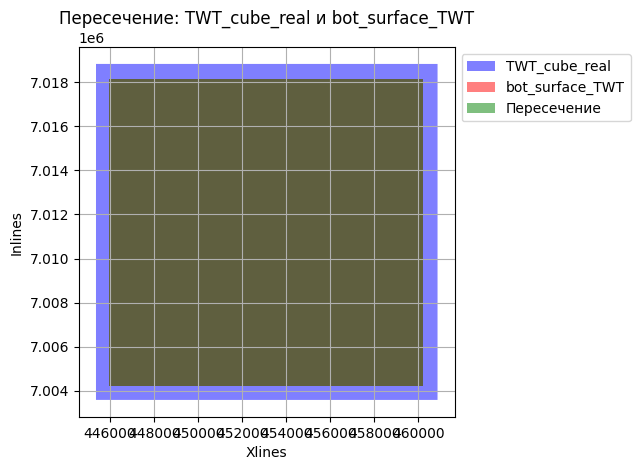

In [260]:
table_result[1][5], table_result[5][1] = peresechenie(TWT_cube_real, bot_surface_TWT, 'TWT_cube_real', 'bot_surface_TWT')

In [228]:
Surface_attribute = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/Surface_attribute_AmplitudeContrast_HalfEnergy_TWT.txt'))

Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно Surface_attribute: 100.00%


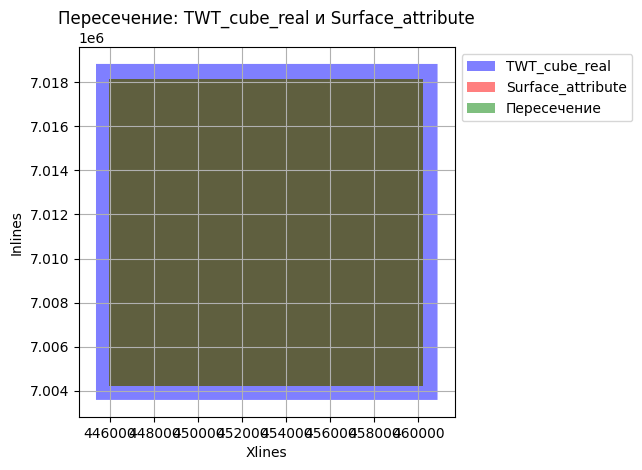

In [229]:
table_result[1][6], table_result[6][1] = peresechenie(TWT_cube_real, Surface_attribute, 'TWT_cube_real', 'Surface_attribute')

Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно top_surface_TVDSS: 100.00%


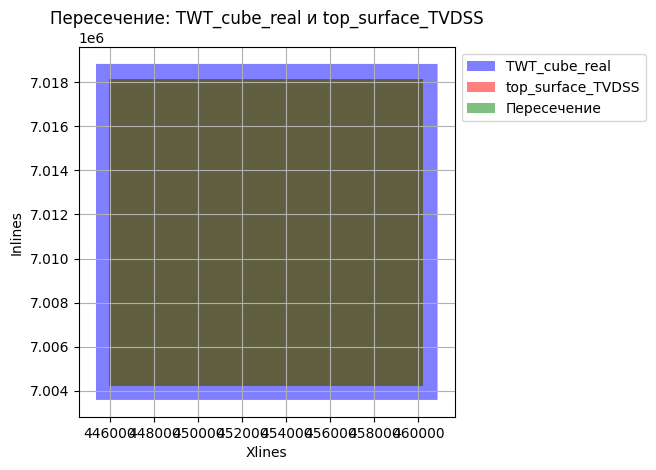

In [230]:
top_surface_TVDSS = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/TVDSS_Top_U1.txt'))
table_result[1][8], table_result[8][1] = peresechenie(TWT_cube_real, top_surface_TVDSS, 'TWT_cube_real', 'top_surface_TVDSS')

Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно bot_surface_TVDSS: 100.00%


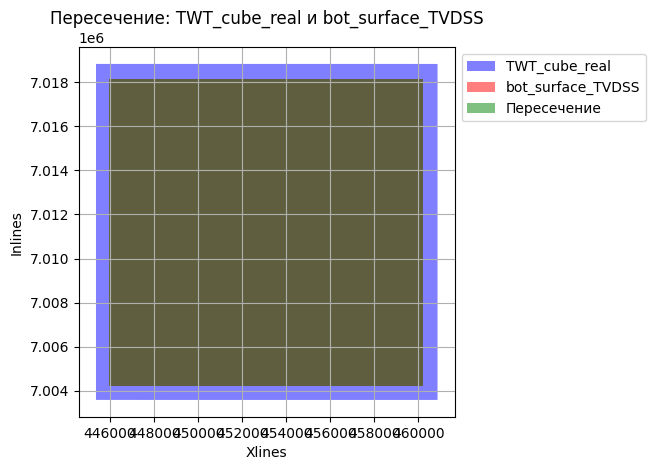

In [231]:
bot_surface_TVDSS = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/TVDSS_Bottom_U1.txt'))
table_result[1][9], table_result[9][1] = peresechenie(TWT_cube_real, bot_surface_TVDSS, 'TWT_cube_real', 'bot_surface_TVDSS')

Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно lateral_trend: 100.00%


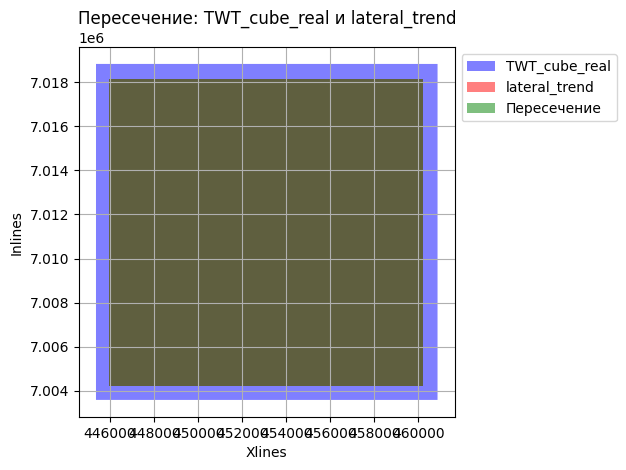

In [232]:
lateral_trend = create_convex_hull(gorizont_coord('C:/HV/Seismic/datas/Effective_thickness_calculated_by_surface_attributes.txt'))
table_result[1][10], table_result[10][1] = peresechenie(TWT_cube_real, lateral_trend, 'TWT_cube_real', 'lateral_trend')

In [233]:
#для model_area_boundary и licence_area_boundary
def read_coordinates(file_path):
    coordinates = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Убираем пробелы и разделяем строку на элементы
            parts = line.strip().split()
            
            # Проверяем, что строка не является строкой конца файла
            if parts[0] == '999.0' and parts[1] == '999.0' and parts[2] == '999.0':
                break
            
            # Преобразуем первую и вторую колонки в int и добавляем в список
            x = int(float(parts[0]))  # Преобразуем в float, а затем в int
            y = int(float(parts[1]))  # Преобразуем в float, а затем в int
            
            coordinates.append([x, y])
    
    return coordinates


Общая площадь пересечения: 201027798.5
Процент пересечения относительно TWT_cube_real: 84.88%
Процент пересечения относительно model_area_boundary: 100.00%


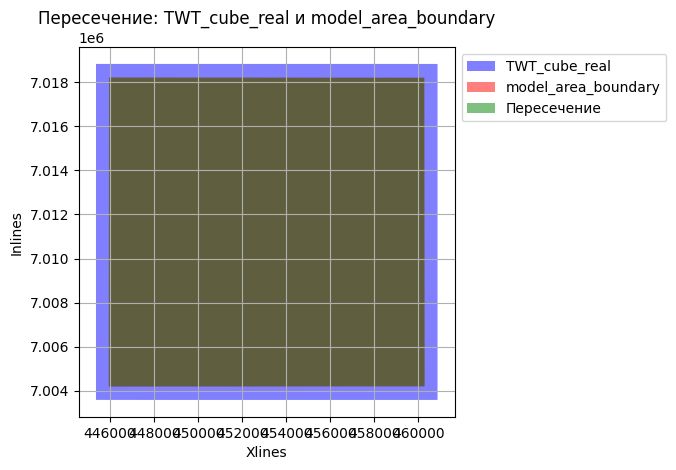

In [234]:
model_area_boundary = create_convex_hull(read_coordinates('C:/HV/Seismic/datas/Model_area_boundary_IRAP_ASCII.txt'))
table_result[1][11], table_result[11][1] = peresechenie(TWT_cube_real, model_area_boundary, 'TWT_cube_real', 'model_area_boundary')

Общая площадь пересечения: 102239533.0
Процент пересечения относительно TWT_cube_real: 43.17%
Процент пересечения относительно licence_area_boundary: 100.00%


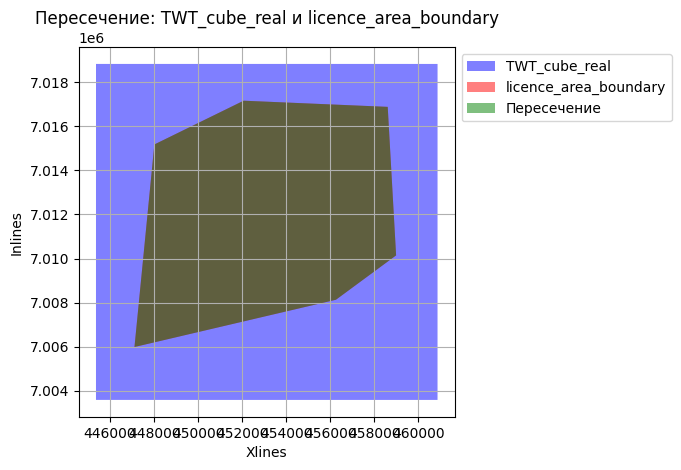

In [235]:
licence_area_boundary = create_convex_hull(read_coordinates('C:/HV/Seismic/datas/Licence_area_boundary_IRAP_ASCII.txt'))
table_result[1][12], table_result[12][1] = peresechenie(TWT_cube_real, licence_area_boundary, 'TWT_cube_real', 'licence_area_boundary')

In [167]:
# ридер для разломов
def process_files(directory):
    files = os.listdir(directory)
    result = {}

    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(directory, file), 'r') as f:
                data = []
                for line in f:
                    fields = line.split()
                    if len(fields) >= 8:
                        x = int(float(fields[3]))
                        y = int(float(fields[4]))
                        z = -int(float(fields[5]))
                        t = int(fields[7])
                        data.append([x, y, z, t])
                result[file] = data
    #return result
    
    
    """
    Сборка координат в один список попарно
    Если точек больше 2, то берется минимальное и максимальное значение по глубинам
    Если точка 1, то она не учитывается в разломах
    """
    faults_final = {}

    for key in result:
        dop_spisok = []
        z_spisok = []
        faults_final[key] = []

        for i in range(len(result[key])):
            if len(dop_spisok) == 0:
                dop_spisok.append(result[key][i])
                z_spisok.append(result[key][i][2])
            elif len(dop_spisok) == 1:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
            elif len(dop_spisok) == 2:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    
                    #faults_final.append(dop_spisok[:])
                    faults_final[key].append(dop_spisok[:])
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
            else:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    faults_final[key].append([dop_spisok[z_spisok.index(min(z_spisok))], dop_spisok[z_spisok.index(max(z_spisok))]])
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])  
    return faults_final
    
    

In [168]:
directory = 'C:/HV/Seismic/datas/Faults_TWT_Charisma_fault_sticks_ASCII'
faults = process_files(directory)

Общая площадь пересечения: 6236974.0
Суммарный процент пересечения относительно TWT_cube_real: 2.63%
Суммарный процент пересечения относительно Fault_polygons_TWT: 100.00%


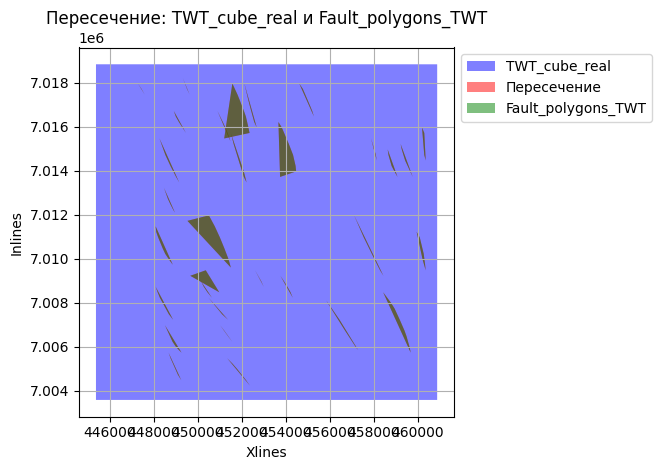

In [262]:
faults_coord_top = []
j = 0
for key in faults:
    faults_coord_top.append([])
    for i in range(len(faults[key])):
        faults_coord_top[j].append([faults[key][i][0][0], faults[key][i][0][1]])
    j+=1
Fault_polygons_TWT = []
for i in range(len(faults_coord_top)):
    Fault_polygons_TWT.append(create_convex_hull(faults_coord_top[i]))

table_result[1][7], table_result[7][1] = peresechenie_2(TWT_cube_real, Fault_polygons_TWT, 'TWT_cube_real', 'Fault_polygons_TWT')

In [311]:

table_result[1][2], table_result[2][1] = peresechenie(TWT_cube_real, Volume_attribute_1, 0, 'TWT_cube', 'Volume_attribute_1')
table_result[1][3], table_result[3][1] = peresechenie(TWT_cube_real, Volume_attribute_2, 0,  'TWT_cube', 'Volume_attribute_2')
table_result[1][4], table_result[4][1] = peresechenie(TWT_cube_real, top_surface_TWT, 0, 'TWT_cube_real', 'top_surface_TWT')
table_result[1][5], table_result[5][1] = peresechenie(TWT_cube_real, bot_surface_TWT, 0, 'TWT_cube_real', 'bot_surface_TWT')
table_result[1][6], table_result[6][1] = peresechenie(TWT_cube_real, Surface_attribute, 0, 'TWT_cube_real', 'Surface_attribute')
table_result[1][7], table_result[7][1] = peresechenie_2(TWT_cube_real, Fault_polygons_TWT, 0, 'TWT_cube_real', 'Fault_polygons_TWT')
table_result[1][8], table_result[8][1] = peresechenie(TWT_cube_real, top_surface_TVDSS, 0, 'TWT_cube_real', 'top_surface_TVDSS')
table_result[1][9], table_result[9][1] = peresechenie(TWT_cube_real, bot_surface_TVDSS, 0,'TWT_cube_real', 'bot_surface_TVDSS')
table_result[1][10], table_result[10][1] = peresechenie(TWT_cube_real, lateral_trend, 0,'TWT_cube_real', 'lateral_trend')
table_result[1][11], table_result[11][1] = peresechenie(TWT_cube_real, model_area_boundary, 0,'TWT_cube_real', 'model_area_boundary')
table_result[1][12], table_result[12][1] = peresechenie(TWT_cube_real, licence_area_boundary, 0,'TWT_cube_real', 'licence_area_boundary')

Сравнение  TWT_cube  и  Volume_attribute_1
Общая площадь пересечения: 236837086.0
Процент пересечения относительно TWT_cube: 100.00%
Процент пересечения относительно Volume_attribute_1: 100.00%
Сравнение  TWT_cube  и  Volume_attribute_2
Общая площадь пересечения: 236837086.0
Процент пересечения относительно TWT_cube: 100.00%
Процент пересечения относительно Volume_attribute_2: 100.00%
Сравнение  TWT_cube_real  и  top_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно top_surface_TWT: 100.00%
Сравнение  TWT_cube_real  и  bot_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно bot_surface_TWT: 100.00%
Сравнение  TWT_cube_real  и  Surface_attribute
Общая площадь пересечения: 198787500.0
Процент пересечения относительно TWT_cube_real: 83.93%
Процент пересечения относительно Surface_attribute: 100.00%
Сравнение  TWT_cu

In [312]:
table_result[2][3], table_result[3][2] = peresechenie(Volume_attribute_1, Volume_attribute_2, 0,'Volume_attribute_1', 'Volume_attribute_2')
table_result[2][4], table_result[4][2] = peresechenie(Volume_attribute_1, top_surface_TWT, 0,'Volume_attribute_1', 'top_surface_TWT')
table_result[2][5], table_result[5][2] = peresechenie(Volume_attribute_1, bot_surface_TWT, 0,'Volume_attribute_1', 'bot_surface_TWT')
table_result[2][6], table_result[6][2] = peresechenie(Volume_attribute_1, Surface_attribute, 0,'Volume_attribute_1', 'Surface_attribute')
table_result[2][7], table_result[7][2] = peresechenie_2(Volume_attribute_1, Fault_polygons_TWT, 0,'Volume_attribute_1', 'Fault_polygons_TWT')
table_result[2][8], table_result[8][2] = peresechenie(Volume_attribute_1, top_surface_TVDSS, 0,'Volume_attribute_1', 'top_surface_TVDSS')
table_result[2][9], table_result[9][2] = peresechenie(Volume_attribute_1, bot_surface_TVDSS, 0,'Volume_attribute_1', 'bot_surface_TVDSS')
table_result[2][10], table_result[10][2] = peresechenie(Volume_attribute_1, lateral_trend, 0,'Volume_attribute_1', 'lateral_trend')
table_result[2][11], table_result[11][2] = peresechenie(Volume_attribute_1, model_area_boundary, 0,'Volume_attribute_1', 'model_area_boundary')
table_result[2][12], table_result[12][2] = peresechenie(Volume_attribute_1, licence_area_boundary, 0,'Volume_attribute_1', 'licence_area_boundary')

Сравнение  Volume_attribute_1  и  Volume_attribute_2
Общая площадь пересечения: 236837086.0
Процент пересечения относительно Volume_attribute_1: 100.00%
Процент пересечения относительно Volume_attribute_2: 100.00%
Сравнение  Volume_attribute_1  и  top_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_1: 83.93%
Процент пересечения относительно top_surface_TWT: 100.00%
Сравнение  Volume_attribute_1  и  bot_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_1: 83.93%
Процент пересечения относительно bot_surface_TWT: 100.00%
Сравнение  Volume_attribute_1  и  Surface_attribute
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_1: 83.93%
Процент пересечения относительно Surface_attribute: 100.00%
Сравнение  Volume_attribute_1  и  Fault_polygons_TWT
Общая площадь пересечения: 6236974.0
Суммарный процент пересечения относительно Volume_attribute_1: 2.63%
Су

In [313]:
k=3
table_result[k][4], table_result[4][k] = peresechenie(Volume_attribute_2, top_surface_TWT,0, 'Volume_attribute_2', 'top_surface_TWT')
table_result[k][5], table_result[5][k] = peresechenie(Volume_attribute_2, bot_surface_TWT, 0,'Volume_attribute_2', 'bot_surface_TWT')
table_result[k][6], table_result[6][k] = peresechenie(Volume_attribute_2, Surface_attribute,0, 'Volume_attribute_2', 'Surface_attribute')
table_result[k][7], table_result[7][k] = peresechenie_2(Volume_attribute_2, Fault_polygons_TWT,0, 'Volume_attribute_2', 'Fault_polygons_TWT')
table_result[k][8], table_result[8][k] = peresechenie(Volume_attribute_2, top_surface_TVDSS, 0,'Volume_attribute_2', 'top_surface_TVDSS')
table_result[k][9], table_result[9][k] = peresechenie(Volume_attribute_2, bot_surface_TVDSS, 0,'Volume_attribute_2', 'bot_surface_TVDSS')
table_result[k][10], table_result[10][k] = peresechenie(Volume_attribute_2, lateral_trend, 0,'Volume_attribute_2', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(Volume_attribute_2, model_area_boundary, 0,'Volume_attribute_2', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(Volume_attribute_2, licence_area_boundary, 0,'Volume_attribute_2', 'licence_area_boundary')

Сравнение  Volume_attribute_2  и  top_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_2: 83.93%
Процент пересечения относительно top_surface_TWT: 100.00%
Сравнение  Volume_attribute_2  и  bot_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_2: 83.93%
Процент пересечения относительно bot_surface_TWT: 100.00%
Сравнение  Volume_attribute_2  и  Surface_attribute
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_2: 83.93%
Процент пересечения относительно Surface_attribute: 100.00%
Сравнение  Volume_attribute_2  и  Fault_polygons_TWT
Общая площадь пересечения: 6236974.0
Суммарный процент пересечения относительно Volume_attribute_2: 2.63%
Суммарный процент пересечения относительно Fault_polygons_TWT: 100.00%
Сравнение  Volume_attribute_2  и  top_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Volume_attribute_2: 8

In [314]:
k=4
table_result[k][5], table_result[5][k] = peresechenie(top_surface_TWT, bot_surface_TWT, 0,'top_surface_TWT', 'bot_surface_TWT')
table_result[k][6], table_result[6][k] = peresechenie(top_surface_TWT, Surface_attribute, 0,'top_surface_TWT', 'Surface_attribute')
table_result[k][7], table_result[7][k] = peresechenie_2(top_surface_TWT, Fault_polygons_TWT,0, 'top_surface_TWT', 'Fault_polygons_TWT')
table_result[k][8], table_result[8][k] = peresechenie(top_surface_TWT, top_surface_TVDSS, 0,'top_surface_TWT', 'top_surface_TVDSS')
table_result[k][9], table_result[9][k] = peresechenie(top_surface_TWT, bot_surface_TVDSS, 0,'top_surface_TWT', 'bot_surface_TVDSS')
table_result[k][10], table_result[10][k] = peresechenie(top_surface_TWT, lateral_trend, 0,'top_surface_TWT', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(top_surface_TWT, model_area_boundary, 0,'top_surface_TWT', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(top_surface_TWT, licence_area_boundary, 0,'top_surface_TWT', 'licence_area_boundary')

Сравнение  top_surface_TWT  и  bot_surface_TWT
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TWT: 100.00%
Процент пересечения относительно bot_surface_TWT: 100.00%
Сравнение  top_surface_TWT  и  Surface_attribute
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TWT: 100.00%
Процент пересечения относительно Surface_attribute: 100.00%
Сравнение  top_surface_TWT  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно top_surface_TWT: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  top_surface_TWT  и  top_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TWT: 100.00%
Процент пересечения относительно top_surface_TVDSS: 100.00%
Сравнение  top_surface_TWT  и  bot_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TWT: 100.00%
Процент п

In [315]:
k=5
table_result[k][6], table_result[6][k] = peresechenie(bot_surface_TWT, Surface_attribute, 0,'bot_surface_TWT', 'Surface_attribute')
table_result[k][7], table_result[7][k] = peresechenie_2(bot_surface_TWT, Fault_polygons_TWT,0, 'bot_surface_TWT', 'Fault_polygons_TWT')
table_result[k][8], table_result[8][k] = peresechenie(bot_surface_TWT, top_surface_TVDSS, 0,'bot_surface_TWT', 'top_surface_TVDSS')
table_result[k][9], table_result[9][k] = peresechenie(bot_surface_TWT, bot_surface_TVDSS, 0,'bot_surface_TWT', 'bot_surface_TVDSS')
table_result[k][10], table_result[10][k] = peresechenie(bot_surface_TWT, lateral_trend, 0,'bot_surface_TWT', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(bot_surface_TWT, model_area_boundary,0, 'bot_surface_TWT', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(bot_surface_TWT, licence_area_boundary,0, 'bot_surface_TWT', 'licence_area_boundary')

Сравнение  bot_surface_TWT  и  Surface_attribute
Общая площадь пересечения: 198787500.0
Процент пересечения относительно bot_surface_TWT: 100.00%
Процент пересечения относительно Surface_attribute: 100.00%
Сравнение  bot_surface_TWT  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно bot_surface_TWT: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  bot_surface_TWT  и  top_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно bot_surface_TWT: 100.00%
Процент пересечения относительно top_surface_TVDSS: 100.00%
Сравнение  bot_surface_TWT  и  bot_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно bot_surface_TWT: 100.00%
Процент пересечения относительно bot_surface_TVDSS: 100.00%
Сравнение  bot_surface_TWT  и  lateral_trend
Общая площадь пересечения: 198787500.0
Процент пересечения относительно bot_surface_TWT: 100.00%
Процент п

In [316]:
k=6
table_result[k][7], table_result[7][k] = peresechenie_2(Surface_attribute, Fault_polygons_TWT,0, 'Surface_attribute', 'Fault_polygons_TWT')
table_result[k][8], table_result[8][k] = peresechenie(Surface_attribute, top_surface_TVDSS, 0,'Surface_attribute', 'top_surface_TVDSS')
table_result[k][9], table_result[9][k] = peresechenie(Surface_attribute, bot_surface_TVDSS, 0,'Surface_attribute', 'bot_surface_TVDSS')
table_result[k][10], table_result[10][k] = peresechenie(Surface_attribute, lateral_trend, 0,'Surface_attribute', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(Surface_attribute, model_area_boundary, 0, 'Surface_attribute', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(Surface_attribute, licence_area_boundary,0, 'Surface_attribute', 'licence_area_boundary')

Сравнение  Surface_attribute  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно Surface_attribute: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  Surface_attribute  и  top_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Surface_attribute: 100.00%
Процент пересечения относительно top_surface_TVDSS: 100.00%
Сравнение  Surface_attribute  и  bot_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Surface_attribute: 100.00%
Процент пересечения относительно bot_surface_TVDSS: 100.00%
Сравнение  Surface_attribute  и  lateral_trend
Общая площадь пересечения: 198787500.0
Процент пересечения относительно Surface_attribute: 100.00%
Процент пересечения относительно lateral_trend: 100.00%
Сравнение  Surface_attribute  и  model_area_boundary
Общая площадь пересечения: 198771909.1048709
Процент пересечения относительно Surface_attr

In [317]:
k=7
table_result[k][8], table_result[8][k] = peresechenie_2(top_surface_TVDSS, Fault_polygons_TWT,0, 'top_surface_TVDSS', 'Fault_polygons_TWT')
table_result[k][9], table_result[9][k] = peresechenie_2(bot_surface_TVDSS, Fault_polygons_TWT,0, 'bot_surface_TVDSS', 'Fault_polygons_TWT')
table_result[k][10], table_result[10][k] = peresechenie_2(lateral_trend, Fault_polygons_TWT, 0,'lateral_trend', 'Fault_polygons_TWT')
table_result[k][11], table_result[11][k] = peresechenie_2(model_area_boundary, Fault_polygons_TWT,0, 'model_area_boundary', 'Fault_polygons_TWT')
table_result[k][12], table_result[12][k] = peresechenie_2(licence_area_boundary, Fault_polygons_TWT, 0,'licence_area_boundary', 'Fault_polygons_TWT')

Сравнение  top_surface_TVDSS  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно top_surface_TVDSS: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  bot_surface_TVDSS  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно bot_surface_TVDSS: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  lateral_trend  и  Fault_polygons_TWT
Общая площадь пересечения: 6103102.323530822
Суммарный процент пересечения относительно lateral_trend: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 97.85%
Сравнение  model_area_boundary  и  Fault_polygons_TWT
Общая площадь пересечения: 6177274.654589983
Суммарный процент пересечения относительно model_area_boundary: 3.07%
Суммарный процент пересечения относительно Fault_polygons_TWT: 99.04%
Сравнение  licence_area_boundary  и  Fault_polygons_TWT
Общая пл

In [318]:
k=8
table_result[k][9], table_result[9][k] = peresechenie(top_surface_TVDSS, bot_surface_TVDSS, 0,'top_surface_TVDSS', 'bot_surface_TVDSS')
table_result[k][10], table_result[10][k] = peresechenie(top_surface_TVDSS, lateral_trend, 0,'top_surface_TVDSS', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(top_surface_TVDSS, model_area_boundary,0, 'top_surface_TVDSS', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(top_surface_TVDSS, licence_area_boundary,0, 'top_surface_TVDSS', 'licence_area_boundary')

Сравнение  top_surface_TVDSS  и  bot_surface_TVDSS
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TVDSS: 100.00%
Процент пересечения относительно bot_surface_TVDSS: 100.00%
Сравнение  top_surface_TVDSS  и  lateral_trend
Общая площадь пересечения: 198787500.0
Процент пересечения относительно top_surface_TVDSS: 100.00%
Процент пересечения относительно lateral_trend: 100.00%
Сравнение  top_surface_TVDSS  и  model_area_boundary
Общая площадь пересечения: 198771909.1048709
Процент пересечения относительно top_surface_TVDSS: 99.99%
Процент пересечения относительно model_area_boundary: 98.88%
Сравнение  top_surface_TVDSS  и  licence_area_boundary
Общая площадь пересечения: 102239533.0
Процент пересечения относительно top_surface_TVDSS: 51.43%
Процент пересечения относительно licence_area_boundary: 100.00%


In [319]:
k=9
table_result[k][10], table_result[10][k] = peresechenie(bot_surface_TVDSS, lateral_trend, 0,'bot_surface_TVDSS', 'lateral_trend')
table_result[k][11], table_result[11][k] = peresechenie(bot_surface_TVDSS, model_area_boundary,0, 'bot_surface_TVDSS', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(bot_surface_TVDSS, licence_area_boundary,0, 'bot_surface_TVDSS', 'licence_area_boundary')

Сравнение  bot_surface_TVDSS  и  lateral_trend
Общая площадь пересечения: 198787500.0
Процент пересечения относительно bot_surface_TVDSS: 100.00%
Процент пересечения относительно lateral_trend: 100.00%
Сравнение  bot_surface_TVDSS  и  model_area_boundary
Общая площадь пересечения: 198771909.1048709
Процент пересечения относительно bot_surface_TVDSS: 99.99%
Процент пересечения относительно model_area_boundary: 98.88%
Сравнение  bot_surface_TVDSS  и  licence_area_boundary
Общая площадь пересечения: 102239533.0
Процент пересечения относительно bot_surface_TVDSS: 51.43%
Процент пересечения относительно licence_area_boundary: 100.00%


In [320]:
k=10
table_result[k][11], table_result[11][k] = peresechenie(lateral_trend, model_area_boundary, 0,'lateral_trend', 'model_area_boundary')
table_result[k][12], table_result[12][k] = peresechenie(lateral_trend, licence_area_boundary, 0,'lateral_trend', 'licence_area_boundary')

Сравнение  lateral_trend  и  model_area_boundary
Общая площадь пересечения: 198771909.1048709
Процент пересечения относительно lateral_trend: 99.99%
Процент пересечения относительно model_area_boundary: 98.88%
Сравнение  lateral_trend  и  licence_area_boundary
Общая площадь пересечения: 102239533.0
Процент пересечения относительно lateral_trend: 51.43%
Процент пересечения относительно licence_area_boundary: 100.00%


In [321]:
k=11
table_result[k][12], table_result[12][k] = peresechenie(model_area_boundary, licence_area_boundary, 0,'model_area_boundary', 'licence_area_boundary')

Сравнение  model_area_boundary  и  licence_area_boundary
Общая площадь пересечения: 102239533.0
Процент пересечения относительно model_area_boundary: 50.86%
Процент пересечения относительно licence_area_boundary: 100.00%


In [287]:
#Вывод таблицы 
data = table_result

# Определяем ширину столбцов
column_widths = [max(len(str(item)) for item in column) for column in zip(*table_result)]

for row in table_result:
    print(" | ".join(f"{str(item):<{column_widths[i]}}" for i, item in enumerate(row)))


Проверка по оси ХУ    | TWT_cube | Volume_attribute_1 | Volume_attribute_2 | top_surface_TWT   | bot_surface_TWT   | Surface_attribute | Fault_polygons_TWT | top_surface_TVDSS | bot_surface_TVDSS | lateral_trend     | model_area_boundary | licence_area_boundary
TWT_cube              | x        | 100.0              | 100.0              | 83.93427877253987 | 83.93427877253987 | 83.93427877253987 | 2.633444831355508  | 83.93427877253987 | 83.93427877253987 | 83.93427877253987 | 84.88020263008978   | 43.16871767287324    
Volume_attribute 1    | 100.0    | x                  | 100.0              | 83.93427877253987 | 83.93427877253987 | 83.93427877253987 | 2.633444831355508  | 83.93427877253987 | 83.93427877253987 | 83.93427877253987 | 84.88020263008978   | 43.16871767287324    
Volume_attribute 2    | 100.0    | 100.0              | x                  | 83.93427877253987 | 83.93427877253987 | 83.93427877253987 | 2.633444831355508  | 83.93427877253987 | 83.93427877253987 | 83.9342787725398

In [288]:
data = table_result

# Создаем DataFrame из данных
df = pd.DataFrame(data[1:], columns=data[0])

# Записываем DataFrame в файл Excel
output_file = "output.xlsx"
df.to_excel(output_file, index=False)

print(f"Данные успешно записаны в файл {output_file}")

Данные успешно записаны в файл output.xlsx
